<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Forward Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>September 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@fr.ey.com</span>
</p>
</CENTER>

In [288]:
import numpy as np
from math import sqrt, exp
from    scipy.signal                                import  lfilter
from    scipy.stats                                 import  norm
from    scipy.optimize                              import  root as root_finder
from abc import ABC, abstractmethod
import utils
from    scipy.special                               import  eval_genlaguerre, comb
from    time                                        import  time
from    sklearn.linear_model                        import  LinearRegression, Ridge, HuberRegressor
from    statsmodels.nonparametric.kernel_regression import  KernelReg
import  statsmodels.api                             as      sm
from    sklearn.neighbors                           import  KNeighborsRegressor
import matplotlib.pyplot as plt
import  torch
import  torch.nn                as      nn
from torch.utils.data import DataLoader, TensorDataset

In [289]:
np.random.seed(0)
plt.style.use('ggplot')

In [290]:
class PricingModel(ABC):
    def __init__(self, spot):
        self.spot = spot

    @abstractmethod
    def generate_paths(self, num_paths):
        pass

    def set_time_grid(self, time_grid):
        self.time_grid = time_grid

    def set_spot(self, spot):
        self.spot = spot

class BlackScholes(PricingModel):
    def __init__(self, volatility, riskfree_rate, spot):
        super().__init__(spot)
        self.volatility     = volatility
        self.riskfree_rate  = riskfree_rate

    def generate_paths(self, num_paths):
        paths           = np.zeros((num_paths, self.time_grid.num_steps + 1))
        paths[:, 0]     = self.spot
        Z               = np.random.normal(0, 1, size=(num_paths, self.time_grid.num_steps))
        increments      = np.exp((self.riskfree_rate - 0.5 * self.volatility ** 2) * self.time_grid.timestep + self.volatility * sqrt(self.time_grid.timestep) * Z)
        paths[:, 1:]    = self.spot * np.cumprod(increments, axis=1)
        return paths
    
    
class YieldCurve:
    def __init__(self, C1, C2, C3):
        self.C1 = C1
        self.C2 = C2
        self.C3 = C3
    
    def zero_coupon_yield(self, maturity):
        return self.C1 + self.C2 * np.exp(self.C3 * maturity)
    
    def d1_zero_coupon_yield(self, maturity):
        return self.C2 * self.C3 * np.exp(self.C3*maturity)
    
    def d2_zero_coupon_yield(self, maturity):
        return self.C3 * self.d1_zero_coupon_yield(maturity)
    
    def instantaneous_forward_rate(self, maturity):
        return  self.d1_zero_coupon_yield(maturity)*maturity + self.zero_coupon_yield(maturity)
    
    def d1_instantaneous_forward_rate(self, maturity):
        return self.d2_zero_coupon_yield(maturity)*maturity + 2*self.d1_zero_coupon_yield(maturity)
    
    def zero_coupon_price(self, maturity):
        return np.exp(-self.zero_coupon_yield(maturity) * maturity)
    

class TimeGrid:
    def __init__(self, timestep, time_horizon, start_time=0):
        self.start_time     = start_time
        self.timestep       = timestep
        self.time_horizon   = time_horizon
        self.grid = np.linspace(start_time, start_time+time_horizon, int(time_horizon/timestep)+1)
        self.num_steps      = len(self.grid) - 1
    
    def find_index(self, t):
        return int((t-self.start_time) / self.timestep)

class OneFactorHullWhite(PricingModel):
    def __init__(self, volatility, mean_reversion_speed, yield_curve):
        super().__init__(yield_curve.zero_coupon_yield(0))
        self.volatility             = volatility
        self.mean_reversion_speed   = mean_reversion_speed
        self.yield_curve            = yield_curve
        self.longterm_mean          = lambda t: yield_curve.d1_instantaneous_forward_rate(t) + mean_reversion_speed*yield_curve.instantaneous_forward_rate(t) + volatility**2/(2*mean_reversion_speed) * (1 - np.exp(-2*mean_reversion_speed*t))

    def beta(self, t):
        return self.yield_curve.zero_coupon_yield(t) + self.volatility**2/(2*self.mean_reversion_speed**2) * (1 - np.exp(-self.mean_reversion_speed*t))**2
    
    def generate_paths(self, num_paths):
        beta_vals   = self.beta(self.time_grid.grid)
        m_vals      = beta_vals[1:] - beta_vals[:-1]*exp(-self.mean_reversion_speed*self.time_grid.timestep)
        Z           = np.random.normal(0, 1, size=(num_paths, self.time_grid.num_steps))
        X           = m_vals[None, :] + np.sqrt(self.volatility**2/(2*self.mean_reversion_speed)*(1-np.exp(-2*self.mean_reversion_speed*self.time_grid.timestep))) * Z
        y, _        = lfilter(b=[1.0], a=[1.0, -exp(-self.mean_reversion_speed*self.time_grid.timestep)], x=X, axis=1, zi=np.full((num_paths, 1), self.spot))
        paths       = np.concatenate([self.spot * np.ones((num_paths, 1)), y], axis=1)
        return paths

In [291]:
class PricingEngine(ABC):
    def __init__(self, maturity, pricing_model):
        self.maturity       = maturity
        self.pricing_model  = pricing_model

    @abstractmethod
    def generate_paths(self, risk_factors_paths):
        pass

class AnalyticalPricingEngine(PricingEngine):
    def __init__(self, maturity, pricing_model):
        super().__init__(maturity, pricing_model)

    @abstractmethod
    def get_conditional_quantile(self, level, delta, tref, risk_factors_vals):
        pass

class PutBlackScholes(AnalyticalPricingEngine):
    def __init__(self, strike, maturity, black_scholes):
        super().__init__(maturity, black_scholes)
        self.strike = strike
    
    def generate_paths(self, stock_price_paths):
        def d1(stock_price, t):
            return (np.log(stock_price/self.strike) + (self.pricing_model.riskfree_rate + 0.5*self.pricing_model.volatility**2)*(self.maturity-t)) / (self.pricing_model.volatility*np.sqrt(self.maturity-t))
        def d2(stock_price, t):
            return d1(stock_price, t) - self.pricing_model.volatility*np.sqrt(self.maturity-t)
        def put_price(stock_price, t):
            d1_val = d1(stock_price, t)
            d2_val = d2(stock_price, t)
            return self.strike*np.exp(-self.pricing_model.riskfree_rate*(self.maturity-t))*norm.cdf(-d2_val) - stock_price*norm.cdf(-d1_val)

        num_paths       = stock_price_paths.shape[0]
        time_grid       = self.pricing_model.time_grid
        paths           = np.zeros((num_paths, time_grid.num_steps+1))
        paths[:, :-1]   = put_price(stock_price_paths[:, :-1], time_grid.grid[:-1])
        if time_grid.grid[-1] == self.maturity:
            paths[:, -1] = np.maximum(self.strike-stock_price_paths[:, -1], 0)
        else:
            paths[:, -1] = put_price(stock_price_paths[:, -1], time_grid.grid[-1])
        return paths
    

    def get_conditional_quantile(self, level, delta, tref, risk_factors_vals):
        condquant_risk_factors  = risk_factors_vals * exp((self.pricing_model.riskfree_rate-0.5*self.pricing_model.volatility**2)*delta + self.pricing_model.volatility*sqrt(delta)*norm.ppf(1-level))
        init_time_grid          = self.pricing_model.time_grid
        self.pricing_model.set_time_grid(TimeGrid(init_time_grid.timestep, 0, tref+delta))
        cond_quant = self.generate_paths(condquant_risk_factors.reshape(-1, 1))
        self.pricing_model.set_time_grid(init_time_grid)
        return cond_quant.reshape(-1)

class ZeroCouponOneFactorHullWhite(PricingEngine):
    def __init__(self, maturity, hull_white):
        super().__init__(maturity, hull_white)

    def generate_paths(self, riskfree_rate_paths):
        k = self.pricing_model.mean_reversion_speed
        def n(t):
            return (1-np.exp(-k*(self.maturity-t)))/k
        def m(t):
            obs_zc_price    = lambda t: self.pricing_model.yield_curve.zero_coupon_price(t)
            obs_yield_curve = lambda t: self.pricing_model.yield_curve.zero_coupon_yield(t)
            return np.log(obs_zc_price(self.maturity)/obs_zc_price(t)) + n(t)*obs_yield_curve(t) - self.pricing_model.volatility**2/(4*k)*n(t)**2*(1 - np.exp(-2*k*t))
    
        return np.exp(m(self.pricing_model.time_grid.grid) - n(self.pricing_model.time_grid.grid) * riskfree_rate_paths)
    

class PutZeroCouponHullWhite(PricingEngine):
    def __init__(self, strike, maturity, zc_maturity, hull_white):
        super().__init__(maturity, hull_white)
        self.strike         = strike
        self.zc_maturity    = zc_maturity

    def generate_paths(self, riskfree_rate_paths, zc1_paths, zc2_paths):
        def var_integral(t):
            k = self.pricing_model.mean_reversion_speed
            return self.pricing_model.volatility/k * (1 -exp(-k*(self.zc_maturity-self.maturity))) * np.sqrt((1 - np.exp(-2*k*(self.maturity-t)))/(2*k))
        def d1(zc1_price, zc2_price, var):
            return (np.log(zc2_price/(self.strike*zc1_price)) + 0.5*var) / np.sqrt(var)
        def d2(zc1_price, zc2_price, var):
            return d1(zc1_price, zc2_price, var) - np.sqrt(var)
        def put_price(zc1_price, zc2_price, t):
            var     = var_integral(t)
            d1_val  = d1(zc1_price, zc2_price, var)
            d2_val  = d2(zc1_price, zc2_price, var)
            return self.strike*zc1_price*norm.cdf(-d2_val) - zc2_price*norm.cdf(-d1_val)
        
        num_paths       = riskfree_rate_paths.shape[0]
        time_grid       = self.pricing_model.time_grid
        paths           = np.zeros((num_paths, time_grid.num_steps+1))
        paths[:, :-1]   = put_price(zc1_paths[:, :-1], zc2_paths[:, :-1], time_grid.grid[:-1])
        if time_grid.grid[-1] == self.maturity:
            paths[:, -1] = np.maximum(self.strike-zc2_paths[:, -1], 0)
        else:
            paths[:, -1] = put_price(zc1_paths[:, -1],  zc2_paths[:, -1], time_grid.grid[-1])
        return paths


class SwaptionOneFactorHullWhite(AnalyticalPricingEngine):
    def __init__(self, maturity, swap_strike, swap_time_grid, swap_notional, hull_white):
        super().__init__(maturity, hull_white)
        self.swap_strike            = swap_strike
        self.swap_time_grid         = swap_time_grid
        self.swap_notional          = swap_notional

    def generate_paths(self, riskfree_rate_paths):
        k               = self.pricing_model.mean_reversion_speed
        fixing_dates    = self.swap_time_grid.grid + self.maturity + self.swap_time_grid.timestep
        def psi(t, Tfix):
            return self.pricing_model.volatility/k * (exp(-k*t) - np.exp(-k*Tfix))
        def mu(t, Tfix):
            obs_zc_price    = lambda t: self.pricing_model.yield_curve.zero_coupon_price(t)
            int1            = self.pricing_model.volatility**2/k**3 * (1 + np.exp(-k*Tfix) - exp(-k*t) - np.exp(-k*(Tfix-t)) + 1/4*(np.exp(-2*k*(Tfix-t)) - 1))
            int2            = self.pricing_model.volatility**2/k**3 * (np.exp(-k*(Tfix-t)) - np.exp(-k*Tfix) - 1 + exp(-k*t) - np.exp(-k*(Tfix+self.maturity-2*t)) + np.exp(-k*(Tfix+self.maturity)) + exp(-k*(self.maturity-t)) - exp(-k*(t+self.maturity)))
            return np.log(obs_zc_price(Tfix)/ obs_zc_price(t)) - int1 + int2

        c           = np.concatenate([self.swap_time_grid.timestep*self.swap_strike*np.ones(self.swap_time_grid.num_steps), [1+self.swap_time_grid.timestep*self.swap_strike]], axis=0)
        K           = 1
        mu_vals     = mu(self.maturity, fixing_dates)
        psi_vals    = psi(self.maturity, fixing_dates)
        f           = lambda y: np.sum(c*np.exp(mu_vals - psi_vals*y)) - K
        ybar        = root_finder(f, 0, method='hybr').x
        Kjam        = np.exp(mu_vals - psi_vals*ybar)
        zc1         = ZeroCouponOneFactorHullWhite(self.maturity, self.pricing_model)
        zc1_paths   = zc1.generate_paths(riskfree_rate_paths)
        paths       = np.zeros_like(riskfree_rate_paths)
        for j in range(len(fixing_dates)):
            zc2         = ZeroCouponOneFactorHullWhite(fixing_dates[j], self.pricing_model)
            zc2_paths   = zc2.generate_paths(riskfree_rate_paths)
            put         = PutZeroCouponHullWhite(Kjam[j], self.maturity, fixing_dates[j], self.pricing_model)
            put_paths   = put.generate_paths(riskfree_rate_paths, zc1_paths, zc2_paths)
            paths       += c[j] * put_paths
        paths *= self.swap_notional
        return paths
    
    def get_conditional_quantile(self, level, delta, tref, risk_factors_vals):
        k                       = self.pricing_model.mean_reversion_speed
        mean                    = risk_factors_vals*exp(-k*delta) + self.pricing_model.beta(tref+delta) - self.pricing_model.beta(tref) * exp(-k*delta)
        variance                = self.pricing_model.volatility**2/(2*k) * (1 - np.exp(-2*k*delta))
        condquant_risk_factors  = mean + np.sqrt(variance)*norm.ppf(level)
        init_time_grid          = self.pricing_model.time_grid
        self.pricing_model.set_time_grid(TimeGrid(init_time_grid.timestep, 0, tref+delta))
        cond_quant = self.generate_paths(condquant_risk_factors.reshape(-1, 1))
        self.pricing_model.set_time_grid(init_time_grid)
        return cond_quant.reshape(-1)

In [292]:
def get_mtmdiff(mtm_paths, mpor, time_grid):
    inds_offset     = np.clip(np.arange(time_grid.num_steps+1) + time_grid.find_index(mpor), 0, time_grid.num_steps)
    mtmdiff_paths   = mtm_paths[:, inds_offset] - mtm_paths
    return mtmdiff_paths

def get_basis(x, basis_type, order):
    if basis_type == 'laguerre':
        return np.column_stack([eval_genlaguerre(s, 0, x) for s in range(order+1)])
    elif basis_type == 'canonical':
        return np.column_stack([x**s for s in range(order+1)])
    
def get_centred_moms(yhat):
    M, K        = yhat.shape
    zhat        = np.column_stack([np.ones((M, 1)), yhat])
    pows        = np.arange(K+1)
    m1hat_pows  = zhat[:, 1:2]**pows
    temp        = np.ones(M, dtype=bool)

    muhat       = np.zeros((M, K-1))
    maskhat     = np.ones_like(muhat, dtype=bool)
    for k in range(2, K+1):
        coeffs          = (comb(k, pows[:k+1]) * (-1)**pows[k::-1]).reshape(1, -1)
        terms           = coeffs * zhat[:, :k+1] * m1hat_pows[:, k::-1]
        muhat[:, k-2]   = np.sum(terms, axis=1)
        if k%2 == 0:
            temp            &= (yhat[:, k-1]>0)
            maskhat[:, k-2] = temp&(muhat[:, k-2]>0)
        else:
            maskhat[:, k-2] = temp

    return muhat, maskhat


def get_quantile_normal(mu1rawhat, mu2hat, alpha):
    quanthat = norm.ppf(alpha, loc=mu1rawhat.reshape(-1, 1), scale=np.sqrt(mu2hat.reshape(-1, 1)))
    return quanthat


def get_mtmdiff_nmc(num_inner_paths, pricing_engine, risk_factors_vals, mtm_vals, mpor, tref):
    num_paths       = len(risk_factors_vals)
    mtmdiff         = np.zeros((num_paths, num_inner_paths))
    init_time_grid  = pricing_engine.pricing_model.time_grid
    init_spot       = pricing_engine.pricing_model.spot
    delta           = min(init_time_grid.grid[-1] - tref, mpor)
    new_time_grid   = TimeGrid(init_time_grid.timestep, delta, tref)
    for m in range(num_paths):
        pricing_engine.pricing_model.set_time_grid(new_time_grid)
        pricing_engine.pricing_model.set_spot(risk_factors_vals[m])
        risk_factors_nested_paths = pricing_engine.pricing_model.generate_paths(num_inner_paths)
        pricing_engine.pricing_model.set_time_grid(TimeGrid(init_time_grid.timestep, 0, tref+delta))
        mtm_nested_vals = pricing_engine.generate_paths(risk_factors_nested_paths[:, -1:])
        mtmdiff[m, :]   = mtm_nested_vals[:, 0] - mtm_vals[m]
    
    pricing_engine.pricing_model.set_time_grid(init_time_grid)
    pricing_engine.pricing_model.set_spot(init_spot)

    return mtmdiff


def percentile_matching_johnson(tref, mtm_vals, risk_factors_train_vals, mtm_train_vals, pricing_engine, mpor, num_inner_paths, z):
    jtypes_map  = {'SL': 1, 'SU': 2, 'SB': 3, 'SN': 4, 'ST': 5}
    percents    = norm.cdf([3*z, z, -z, -3*z])
    inds        = (mtm_train_vals[:, None] == mtm_vals).argmax(axis=0)
    mtmdiff_nmc = get_mtmdiff_nmc(num_inner_paths, pricing_engine, risk_factors_train_vals[inds], mtm_vals, mpor, tref)
    quant_nmc   = np.zeros((len(percents), mtm_vals.shape[0]))
    for i, perc in enumerate(percents):
        quant_nmc[i, :] = np.quantile(mtmdiff_nmc, perc, axis=1)
        
    m = quant_nmc[0, :] - quant_nmc[1, :]
    n = quant_nmc[2, :] - quant_nmc[3, :]
    p = quant_nmc[1, :] - quant_nmc[2, :]

    jtypehat    =  np.zeros_like(p, dtype=object)
    mask_hat    = np.zeros_like(jtypehat, dtype=bool)
    jparamshat  = np.zeros((len(jtypehat), 4))
    for i in range(len(p)):
        if (p[i]==0):
            jparamshat[i]  = np.repeat(np.nan, 4)
            jtypehat[i]    = None
            continue
        else:
            d = (m[i]*n[i])/p[i]**2
            if (d<0.999) or (d<1 and m[i]<=p[i]):
                jtype = jtypes_map['SB']
            elif (d>1.001) or ((d>1) and (m[i]<=p[i])):
                jtype = jtypes_map['SU']
            else:
                jtype = jtypes_map['SL']
        if jtype == jtypes_map['SU']:
            jparamshat[i, 1]    = 2*z/np.arccosh(1/2*(m[i]/p[i] + n[i]/p[i]))
            jparamshat[i, 0]    = jparamshat[i, 1] * np.arcsinh((n[i]/p[i] - m[i]/p[i]) / (2*np.sqrt(m[i]/p[i] * n[i]/p[i] - 1)))
            jparamshat[i, 2]    = (quant_nmc[1, i] + quant_nmc[2, i])/2 + p[i]*(n[i]/p[i] - m[i]/p[i])/(2*(m[i]/p[i] + n[i]/p[i] - 2))
            jparamshat[i, 3]    = 2*p[i]*np.sqrt(m[i]/p[i] * n[i]/p[i] - 1) / ((m[i]/p[i] + n[i]/p[i] - 2) * np.sqrt(m[i]/p[i] + n[i]/p[i] + 2))
            mask_hat[i]         = True
            jtypehat[i]         = jtype
        elif jtype == jtypes_map['SB']:
            if (m[i]==0) or (n[i]==0):
                # print(f'Warning: impossible region for support point n°{i} - d = {d[i]} (SB): m = {m[i]} ; n = {n[i]}')
                jparamshat[i]  = np.repeat(np.nan, 4)
                jtypehat[i]    = None
            else:
                jparamshat[i, 1]    = z/np.arccosh(1/2*np.sqrt((1+p[i]/m[i]) * (1+p[i]/n[i])))
                jparamshat[i, 0]    = jparamshat[i, 1] * np.arcsinh((p[i]/n[i] - p[i]/m[i]) * np.sqrt((1+p[i]/m[i]) * (1+p[i]/n[i]) - 4) / (2*(p[i]/m[i] * p[i]/n[i] - 1)))
                jparamshat[i, 3]    = p[i]*np.sqrt(((1+p[i]/m[i]) * (1+p[i]/n[i]) - 2)**2 - 4) / (p[i]/m[i]*p[i]/n[i] - 1)
                jparamshat[i, 2]    = (quant_nmc[1, i] + quant_nmc[2, i])/2 - jparamshat[i, 3]/2 + p[i]*(p[i]/n[i] - p[i]/m[i])/(2*(p[i]/m[i] * p[i]/n[i] - 1))
                mask_hat[i]         = True
                jtypehat[i]         = jtype
        elif jtype == jtypes_map['SL']:
            if (m[i]<=p[i]):
                # print(f'Warning: impossible region for support point n°{i} - d = {d[i]} (SL): m = {m[i]} ; p = {p[i]}')
                jparamshat[i]  = np.repeat(np.nan, 4)
                jtypehat[i]    = None
            else:
                jparamshat[i, 1]    = 2*z/np.log(m[i]/p[i])
                jparamshat[i, 0]    = jparamshat[i, 1] * np.log((m[i]/p[i] - 1) / (p[i] * np.sqrt(m[i]/p[i])))
                jparamshat[i, 2]    = (quant_nmc[1, i] + quant_nmc[2, i])/2 - p[i]/2 * (m[i]/p[i] + 1) / (m[i]/p[i] - 1)
                jparamshat[i, 3]    = 1
                mask_hat[i]         = True
                jtypehat[i]         = jtype

    return jparamshat, jtypehat, mask_hat

In [293]:
class RawMomentsRegressor:
    def __init__(self, setting, order_moms):
        self.setting    = setting
        self.order_moms = order_moms

    def fit(self, x_train, y_train):
        method          = self.setting['method']
        ind_start       = 1 if self.setting['regress_mean']==True else 2
        self.models     = []

        if (method == 'LR') or (method == 'HR') or (method == 'GLM'):
            X_train = get_basis(x_train, self.setting['basis_type'], self.setting['order'])
            for j in range(ind_start, self.order_moms+1):
                if (j%2 != 0) and (method == 'GLM'):
                    model = LinearRegression(fit_intercept=False)
                    model.fit(X_train, y_train[:, j-1])
                elif (method == 'LR') and (self.setting['ridge']>0):
                    model = Ridge(alpha=self.setting['ridge'], fit_intercept=False)
                elif method == 'LR':
                    model = LinearRegression(fit_intercept=False)
                elif method == 'HR':
                    model = HuberRegressor(epsilon=self.setting['epsilon'], alpha=self.setting['ridge'] ,fit_intercept=False)
                elif (method == 'GLM') and (self.setting['ridge']>0):
                    model = sm.GLM(y_train[:, j-1], X_train, family=sm.families.Gaussian(link=sm.families.links.Log())).fit_regularized(method='elastic_net', alpha=self.setting['ridge'], L1_wt=0)
                elif method == 'GLM':
                    model = sm.GLM(y_train[:, j-1], X_train, family=sm.families.Gaussian(link=sm.families.links.Log())).fit()
                
                if method != 'GLM':
                    model.fit(X_train, y_train[:, j-1])

                self.models.append(model)
        
        elif method =='KR':
            X_train = x_train.reshape(-1, 1)
            if self.setting['bandwidth'] == 'silverman':
                iqr = np.quantile(x_train, 0.75) - np.quantile(x_train, 0.25)
                bdw = [0.9*min(np.std(x_train), iqr/1.34) * len(x_train)**(-1/5)]
            elif self.setting['bandwidth'] == 'cv_ls':
                bdw = 'cv_ls'
            else:
                bdw = [self.setting['bandwidth']]
            for j in range(ind_start, self.order_moms+1):
                model = KernelReg(endog=y_train[:, j-1], exog=X_train, var_type='c', bw=bdw)
                self.models.append(model)

    def predict(self, x_test):
        method      = self.setting['method']
        ind_start   = 1 if self.setting['regress_mean']==True else 2
        yhat_test   = np.zeros((len(x_test), self.order_moms))
        ind_model   = 0
        for j in range(ind_start, self.order_moms+1):
            model = self.models[ind_model]
            if (method == 'LR') or (method == 'HR') or (method == 'GLM'):
                X_test = get_basis(x_test, self.setting['basis_type'], self.setting['order'])
                yhat_test[:, j-1] = model.predict(X_test)
            elif method =='KR':
                X_test              = x_test.reshape(-1, 1)
                yhat_test[:, j-1]   = model.fit(X_test)[0]
            ind_model += 1
        
        return yhat_test


class JohnsonSupportRegressor:
    def __init__(self, setting):
        self.setting = setting

    def fit(self, x_train, y_train):
        if (len(x_train) == 0) or ((self.setting['method']=='kNN') and (len(x_train)<self.setting['n_neighbors'])):
            self.warning_empty = True
            return
        self.warning_empty = False
        method = self.setting['method']
        if (method == 'LR'):
            X_train     = get_basis(x_train, self.setting['basis_type'], self.setting['order'])
            self.model  = LinearRegression(fit_intercept=False)
        elif (method == 'kNN') or (method == 'KR'):
            X_train = x_train.reshape(-1, 1)
            if method == 'kNN':
                self.model = KNeighborsRegressor(n_neighbors=self.setting['n_neighbors'], weights='distance', algorithm='auto', leaf_size=30, p=2)
            elif method == 'KR':
                if self.setting['bandwidth'] == 'silverman':
                    iqr = np.quantile(x_train, 0.75) - np.quantile(x_train, 0.25)
                    bdw = [0.9*min(np.std(x_train), iqr/1.34) * len(x_train)**(-1/5)]
                elif self.setting['bandwidth'] == 'cv_ls':
                    bdw = 'cv_ls'
                else:
                    bdw = [self.setting['bandwidth']]
                self.model = KernelReg(endog=y_train, exog=X_train, var_type='c', bw=bdw)

        if (method == 'LR') or (method == 'kNN'):
            self.model.fit(X_train, y_train)

    def predict(self, x_test):
        if self.warning_empty:
            return np.zeros_like(x_test)
        method      = self.setting['method']
        if (method == 'LR'):
            X_test = get_basis(x_test, self.setting['basis_type'], self.setting['order'])
            yhat_test = self.model.predict(X_test)
        elif (method == 'kNN') or (method == 'KR'):
            X_test = x_test.reshape(-1, 1)
            if method == 'kNN':
                yhat_test = self.model.predict(X_test)
            elif method == 'KR':
                yhat_test = self.model.fit(X_test)[0]
        return yhat_test

In [294]:
class ForwardInitialMarginModel(ABC):
    def __init__(self, level, mpor, time_grid):
        self.level      = level
        self.mpor       = mpor
        self.time_grid  = time_grid

    def generate_im_profile(self, initial_margin_hat_paths):
        return np.nanquantile(initial_margin_hat_paths, 0.05, axis=0), np.nanmean(initial_margin_hat_paths, axis=0), np.nanquantile(initial_margin_hat_paths, 0.95, axis=0)
    
    def compute_mse(self, initial_margin_hat_paths, initial_margin_paths):
        return np.nanmean((initial_margin_hat_paths - initial_margin_paths)**2)
    
    @abstractmethod
    def generate_paths(self, *args):
        pass

class GaussianLeastSquaresMonteCarlo(ForwardInitialMarginModel):
    def __init__(self, level, mpor, time_grid, moments_regression_setting):
        super().__init__(level, mpor, time_grid)
        self.moments_regression_setting = moments_regression_setting

    def fit(self, mtm_train_paths):
        mtmdiff_train_paths     = get_mtmdiff(mtm_train_paths, self.mpor, self.time_grid)
        self.moments_regressors = []
        for i in range(len(self.time_grid.grid)):
            x_train             = mtm_train_paths[:, i]
            y_train             = mtmdiff_train_paths[:, i].reshape(-1, 1)**np.arange(1, 3)
            if (i<len(self.time_grid.grid)-1) or (np.any(mtmdiff_train_paths[:, -1])):
                moments_regressor   = RawMomentsRegressor(self.moments_regression_setting, 2)
                moments_regressor.fit(x_train, y_train)
                self.moments_regressors.append(moments_regressor)

    def generate_paths(self, mtm_test_paths):
        paths = np.zeros_like(mtm_test_paths)
        for i in range(len(self.time_grid.grid)):
            if (i<len(self.time_grid.grid)-1) or (len(self.moments_regressors)==len(self.time_grid.grid)):
                murawhat                = self.moments_regressors[i].predict(mtm_test_paths[:, i])
                muhat, maskhat          = get_centred_moms(murawhat)
                varhat                  = np.nan * np.ones_like(mtm_test_paths[:, i])
                varhat[maskhat[:, 0]]   = get_quantile_normal(murawhat[maskhat[:, 0], 0], muhat[maskhat[:, 0], 0], self.level).reshape(-1)
                paths[:, i]             = np.maximum(varhat, 0)

        return paths


class JohnsonMonteCarlo(ForwardInitialMarginModel):
    def __init__(self, level, mpor, time_grid, matching_setting, support_values_setting, quantile_function_setting):
        super().__init__(level, mpor, time_grid)
        self.matching_setting           = matching_setting
        self.support_values_setting     = support_values_setting
        self.quantile_function_setting  = quantile_function_setting

    def get_percent_values(self):
        Nq      = self.support_values_setting['initial nb']
        Nqtail  = int(self.support_values_setting['perc add tails']*Nq)//2
        q_main  = np.arange(1, Nq) / Nq
        q_ltail = np.linspace(0, 0.01, Nqtail+2)[1:-1]
        q_utail = np.linspace(0.99, 1, Nqtail+2)[1:-1]
        q_all   = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
        if self.support_values_setting['add ends']:
            q_all = np.concatenate([[0], q_all, [1]])
        q_all = np.unique(q_all)
        return q_all
    
    def generate_paths(self, mtm_test_paths):
        paths = np.zeros_like(mtm_test_paths)
        for i in range(len(self.time_grid.grid)):
            if (i<len(self.time_grid.grid)-1) or (len(self.quantile_functions)==len(self.time_grid.grid)):
                varhat      = self.quantile_functions[i].predict(mtm_test_paths[:, i])
                paths[:, i] = np.maximum(varhat, 0)
        return paths


class JohnsonLeastSquaresMonteCarlo(JohnsonMonteCarlo):
    def __init__(self, level, mpor, time_grid, moments_matching_setting, support_values_setting, quantile_function_setting):
        super().__init__(level, mpor, time_grid, moments_matching_setting, support_values_setting, quantile_function_setting)

    def fit(self, mtm_train_paths):
        self.quantile_functions = []
        mtmdiff_train_paths     = get_mtmdiff(mtm_train_paths, self.mpor, self.time_grid)
        q_all                   = self.get_percent_values()
        for i in range(len(self.time_grid.grid)):
            if (i<len(self.time_grid.grid)-1) or (np.any(mtmdiff_train_paths[:, -1])):
                x_train             = mtm_train_paths[:, i]
                y_train             = mtmdiff_train_paths[:, i].reshape(-1, 1)**np.arange(1, 5)
                moments_regressor   = RawMomentsRegressor(self.matching_setting, 4)
                moments_regressor.fit(x_train, y_train)
                x_supp                      = np.quantile(x_train, q_all, method='inverted_cdf')
                murawhat_supp               = moments_regressor.predict(x_supp)
                muhat_supp, maskhat_supp    = get_centred_moms(murawhat_supp)
                skewhat_supp, kurthat_supp, _, _, mask_tothat_supp  = utils.get_skewkurt(muhat_supp, maskhat_supp)
                jparamshat_supp, jtypehat_supp, mask_hat_supp       = utils.moment_matching_johnson(murawhat_supp[:, 0], muhat_supp[:, 0], skewhat_supp, kurthat_supp, mask_tothat_supp, False)
                jparamshat_supp, jtypehat_supp, x_supp              = jparamshat_supp[mask_hat_supp], jtypehat_supp[mask_hat_supp], x_supp[mask_hat_supp]
                quanthat_supp, mask_hat_supp_johnson                = utils.get_quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([self.level]))
                x_supp, quanthat_supp                               = x_supp[mask_hat_supp_johnson.reshape(-1)], quanthat_supp[mask_hat_supp_johnson]
                quantile_func = JohnsonSupportRegressor(self.quantile_function_setting)
                quantile_func.fit(x_supp, quanthat_supp)
                self.quantile_functions.append(quantile_func)
    

class JohnsonPercentileMatchingMonteCarlo(JohnsonMonteCarlo):
    def __init__(self, level, mpor, time_grid, moments_percentile_setting, support_values_setting, quantile_function_setting):
        super().__init__(level, mpor, time_grid, moments_percentile_setting, support_values_setting, quantile_function_setting)

    def fit(self, risk_factors_train_paths, mtm_train_paths, pricing_engine):
        self.quantile_functions = []
        q_all                   = self.get_percent_values()
        for i in range(len(self.time_grid.grid)):
            if (i<len(self.time_grid.grid)-1) or (len(self.time_grid.grid) < mtm_train_paths.shape[1]):
                xx_train    = risk_factors_train_paths[:, i]
                x_train     = mtm_train_paths[:, i]
                x_supp      = np.quantile(x_train, q_all, method='inverted_cdf')
                jparamshat_supp, jtypehat_supp, mask_hat_supp   = percentile_matching_johnson(self.time_grid.grid[i], x_supp, xx_train, x_train, pricing_engine, self.mpor, self.matching_setting['Nnmc'], self.matching_setting['z'])                
                jparamshat_supp, jtypehat_supp, x_supp          = jparamshat_supp[mask_hat_supp], jtypehat_supp[mask_hat_supp], x_supp[mask_hat_supp]
                quanthat_supp, mask_hat_supp_johnson            = utils.get_quantile_johnson(jparamshat_supp, jtypehat_supp, np.array([self.level]))
                x_supp, quanthat_supp                           = x_supp[mask_hat_supp_johnson.reshape(-1)], quanthat_supp[mask_hat_supp_johnson]
                quantile_func = JohnsonSupportRegressor(self.quantile_function_setting)
                quantile_func.fit(x_supp, quanthat_supp)
                self.quantile_functions.append(quantile_func)

class NonLinearNN(nn.Module):
    def __init__(self, input_dim, n_neurons, n_hidden_layers):
        super().__init__()
        layers = []
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(input_dim if i == 0 else n_neurons, n_neurons, bias=False))
            layers.append(nn.Softplus(beta=1, threshold=20))
        layers.append(nn.Linear(n_neurons, 1, bias=False))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class NeuralQuantileRegression(ForwardInitialMarginModel):
    def __init__(self, level, mpor, time_grid, quantile_function_setting):
        super().__init__(level, mpor, time_grid)
        self.quantile_function_setting = quantile_function_setting

    def fit(self, risk_factors_train_paths, mtm_train_paths):
        self.quantile_functions = []
        mtmdiff_train_paths = get_mtmdiff(mtm_train_paths, self.mpor, self.time_grid)
        pinball_loss = lambda yhat, y: torch.maximum(y - yhat, torch.tensor(0.0))/(1-self.level) + yhat
        for i in range(len(self.time_grid.grid)-1, -1, -1):
            if (i<len(self.time_grid.grid)-1) or (len(self.time_grid.grid) < mtm_train_paths.shape[1]):
                X           = torch.tensor(risk_factors_train_paths[:, i].reshape(-1, 1), dtype=torch.float32)
                X           = (X - X.mean()) / X.std() if X.std() > 0 else X
                ones        = torch.ones(X.size(0), 1, dtype=torch.float32)
                X           = torch.cat((ones, X), dim=1)
                y           = torch.tensor(mtmdiff_train_paths[:, i].reshape(-1, 1), dtype=torch.float32)
                dataset     = TensorDataset(X, y)
                dataloader  = DataLoader(dataset, batch_size=self.quantile_function_setting['batch_size'], shuffle=True)
                model       = NonLinearNN(input_dim=2, n_neurons=self.quantile_function_setting['n_neurons'], n_hidden_layers=self.quantile_function_setting['n_hidden_layers'])
                if len(self.quantile_functions) > 0:
                    model.load_state_dict(self.quantile_functions[0].state_dict())
                crit        = lambda y_hat, y: torch.mean(pinball_loss(y_hat, y))
                if self.quantile_function_setting['optimizer'] == 'sgd':
                    optim = torch.optim.SGD(model.parameters(), lr=self.quantile_function_setting['learning_rate'], weight_decay=self.quantile_function_setting['ridge'])
                elif self.quantile_function_setting['optimizer'] == 'adam':
                    optim = torch.optim.Adam(model.parameters(), lr=self.quantile_function_setting['learning_rate'], weight_decay=self.quantile_function_setting['ridge'])
                for epoch in range(self.quantile_function_setting['n_epochs']):
                    for X_batch, y_batch in dataloader:
                        optim.zero_grad()
                        y_hat   = model(X_batch)
                        loss    = crit(y_hat, y_batch)
                        loss.backward()
                        optim.step()
                self.quantile_functions.insert(0, model)

    def generate_paths(self, risk_factors_test_paths):
        paths = np.zeros((risk_factors_test_paths.shape[0], self.time_grid.num_steps+1))
        for i in range(len(self.time_grid.grid)):
            if (i<len(self.time_grid.grid)-1) or (len(self.quantile_functions)==len(self.time_grid.grid)):
                X       = torch.tensor(risk_factors_test_paths[:, i].reshape(-1, 1), dtype=torch.float32)
                X       = (X - X.mean()) / X.std() if X.std() > 0 else X
                ones    = torch.ones(X.size(0), 1, dtype=torch.float32)
                X       = torch.cat((ones, X), dim=1)
                varhat  = self.quantile_functions[i](X).detach().numpy().reshape(-1)
                paths[:, i] = np.maximum(varhat, 0)
        return paths

class AnalyticalForwardInitialMargin(ForwardInitialMarginModel):
    def __init__(self, level, mpor, time_grid, pricing_engine):
        super().__init__(level, mpor, time_grid)
        self.pricing_engine = pricing_engine

    def generate_paths(self, risk_factors_test_paths, mtm_test_paths):
        paths = np.zeros_like(mtm_test_paths)
        for i in range(len(self.time_grid.grid)):
            if (i<len(self.time_grid.grid)-1) or (len(self.time_grid.grid) < mtm_test_paths.shape[1]):
                delta   = min(self.time_grid.grid[-1] - self.time_grid.grid[i], self.mpor)
                varhat = self.pricing_engine.get_conditional_quantile(self.level, delta, self.time_grid.grid[i], risk_factors_test_paths[:, i])
                paths[:, i] = np.maximum(varhat - mtm_test_paths[:, i], 0)
        return paths
    

class NestedMonteCarloForwardInitialMargin(ForwardInitialMarginModel):
    def __init__(self, level, mpor, time_grid, pricing_engine, num_inner_paths):
        super().__init__(level, mpor, time_grid)
        self.pricing_engine = pricing_engine
        self.num_inner_paths = num_inner_paths

    def generate_paths(self, risk_factors_test_paths, mtm_test_paths):
        paths               = np.zeros((mtm_test_paths.shape[0], self.time_grid.num_steps+1))
        original_timegrid   = self.pricing_engine.pricing_model.time_grid
        for i in range(len(self.time_grid.grid)):
            ind = original_timegrid.find_index(self.time_grid.grid[i])
            if self.time_grid.grid[i] == 0:
                mtmdiff_nmc = get_mtmdiff_nmc(self.num_inner_paths, self.pricing_engine, risk_factors_test_paths[0:1, ind], mtm_test_paths[0:1, ind], self.mpor, self.time_grid.grid[i])
            else:
                mtmdiff_nmc = get_mtmdiff_nmc(self.num_inner_paths, self.pricing_engine, risk_factors_test_paths[:, ind], mtm_test_paths[:, ind], self.mpor, self.time_grid.grid[i])
            varhat = np.quantile(mtmdiff_nmc, self.level, axis=1)
            paths[:, i] = np.maximum(varhat, 0)
        return paths

In [295]:
num_paths   = 10000
maturity    = 1
time_grid   = TimeGrid(1/240, maturity)
alpha       = 0.99
mpor        = 1/24

In [296]:
moment_matching_setting     = {'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': False}
percentile_matching_setting = {'fitting': 'pm', 'Nnmc': 1000, 'z': 1}
support_values_setting      = {'initial nb': 100, 'perc add tails': 0.1, 'add ends': False}
quantile_function_setting   = {'method': 'kNN', 'n_neighbors':3}
nn_function_setting         = {'batch_size': 1000, 'n_neurons': 10, 'n_hidden_layers': 1, 'optimizer': 'adam', 'learning_rate': 0.01, 'ridge': 0.001, 'n_epochs': 50}

num_nested_dates = 3
num_nested_paths = 500
time_grid_nested = TimeGrid(time_grid.time_horizon/(num_nested_dates-1), time_grid.time_horizon)

In [297]:
risk_factor = BlackScholes(0.3, 0.05, 100)
portfolio   = PutBlackScholes(95, maturity, risk_factor)
risk_factor.set_time_grid(time_grid)
risk_factor_paths = risk_factor.generate_paths(num_paths)
mtm_paths = portfolio.generate_paths(risk_factor_paths)

In [298]:
## Analytical ##
groundtruth = AnalyticalForwardInitialMargin(alpha, mpor, time_grid, portfolio)
## NMC ##
#model_nmc = NestedMonteCarloForwardInitialMargin(alpha, mpor, time_grid_nested, portfolio, num_nested_paths)
## GLSMC ##
model_glsmc = GaussianLeastSquaresMonteCarlo(alpha, mpor, time_grid, moment_matching_setting)
print('Fitting GLSMC...')
model_glsmc.fit(mtm_paths)
## JLSMC ##
'''
model_jlsmc = JohnsonLeastSquaresMonteCarlo(alpha, mpor, time_grid, moment_matching_setting, support_values_setting, quantile_function_setting)
print('Fitting JLSMC...')
model_jlsmc.fit(mtm_paths)
'''
## JPMMC ##
'''
model_jpmmc = JohnsonPercentileMatchingMonteCarlo(alpha, mpor, time_grid, percentile_matching_setting, support_values_setting, quantile_function_setting)
print('Fitting JPMMC...')
model_jpmmc.fit(risk_factor_paths, mtm_paths, portfolio)
'''
## ML ##
print('Fitting ML...')
model_ml = NeuralQuantileRegression(alpha, mpor, time_grid, nn_function_setting)
model_ml.fit(risk_factor_paths, mtm_paths)

print('Generating groundtruth IM paths...')
im_true_paths   = groundtruth.generate_paths(risk_factor_paths, mtm_paths)
'''
print('Generating NMC IM paths...')
im_nmc_paths    = model_nmc.generate_paths(risk_factor_paths, mtm_paths)
'''
print('Generating GLSMC IM paths...')
im_glsmc_paths  = model_glsmc.generate_paths(mtm_paths)
'''
print('Generating JLSMC IM paths...')
im_jlsmc_paths  = model_jlsmc.generate_paths(mtm_paths)
print('Generating JPMMC IM paths...')
im_jpmmc_paths  = model_jpmmc.generate_paths(mtm_paths)
'''
print('Generating ML IM paths...')
im_ml_paths     = model_ml.generate_paths(risk_factor_paths)

im_true_profile     = groundtruth.generate_im_profile(im_true_paths)
#im_nmc_profile      = model_nmc.generate_im_profile(im_nmc_paths)
im_glsmc_profile    = model_glsmc.generate_im_profile(im_glsmc_paths)
'''
im_jlsmc_profile    = model_jlsmc.generate_im_profile(im_jlsmc_paths)
im_jpmmc_profile    = model_jpmmc.generate_im_profile(im_jpmmc_paths)
'''
im_ml_profile       = model_ml.generate_im_profile(im_ml_paths)

Fitting GLSMC...
Fitting ML...
Generating groundtruth IM paths...
Generating GLSMC IM paths...
Generating ML IM paths...


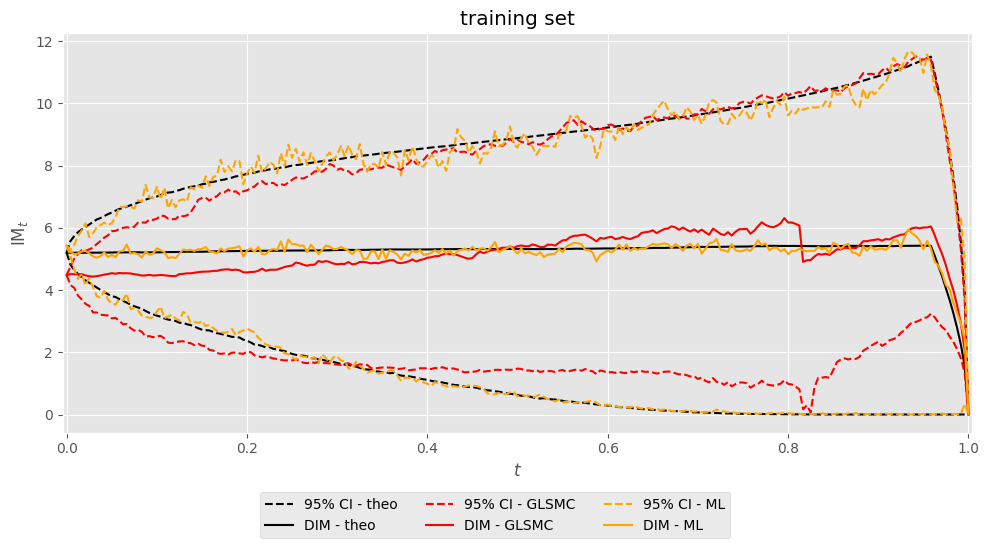

In [299]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(time_grid.grid, im_true_profile[2], linestyle='--', color='black', label='95% CI - theo')
ax.plot(time_grid.grid, im_true_profile[1], color='black', label='DIM - theo')
ax.plot(time_grid.grid, im_true_profile[0],  linestyle='--', color='black')

'''
ax.scatter(time_grid_nested.grid, im_nmc_profile[2], s=30, facecolors='none', color='black', label='95% CI - NMC')
ax.scatter(time_grid_nested.grid, im_nmc_profile[1], s=30, color='black', label='DIM - NMC')
ax.scatter(time_grid_nested.grid, im_nmc_profile[0], s=30, facecolors='none', color='black')
'''

ax.plot(time_grid.grid, im_glsmc_profile[2], linestyle='--', color='red', label='95% CI - GLSMC')
ax.plot(time_grid.grid, im_glsmc_profile[1], color='red', label='DIM - GLSMC')
ax.plot(time_grid.grid, im_glsmc_profile[0], linestyle='--', color='red')

'''
ax.plot(time_grid.grid, im_jlsmc_profile[2], linestyle='--', color='blue', label='95% CI - JLSMC')
ax.plot(time_grid.grid, im_jlsmc_profile[1], color='blue', label='DIM - JLSMC')
ax.plot(time_grid.grid, im_jlsmc_profile[0], linestyle='--', color='blue')

ax.plot(time_grid.grid, im_jpmmc_profile[2], linestyle='--', color='green', label='95% CI - JPMMC')
ax.plot(time_grid.grid, im_jpmmc_profile[1], color='green', label='DIM - JPMMC')
ax.plot(time_grid.grid, im_jpmmc_profile[0], linestyle='--', color='green')
'''

ax.plot(time_grid.grid, im_ml_profile[2], linestyle='--', color='orange', label='95% CI - ML')
ax.plot(time_grid.grid, im_ml_profile[1], color='orange', label='DIM - ML')
ax.plot(time_grid.grid, im_ml_profile[0], linestyle='--', color='orange')

ax.set_xlabel('$t$')
ax.set_ylabel('$\\text{IM}_t$')
ax.set_xlim(np.min(time_grid.grid)-time_grid.timestep, np.max(time_grid.grid)+time_grid.timestep)
ax.set_title('training set')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.show()

In [143]:
risk_factor = OneFactorHullWhite(0.01, 0.015, YieldCurve(0.05, -0.03, -0.18))
portfolio   = SwaptionOneFactorHullWhite(maturity, 0.04, TimeGrid(0.25, 4.75), 10000, risk_factor)
risk_factor.set_time_grid(time_grid)
risk_factor_paths = risk_factor.generate_paths(num_paths)
mtm_paths = portfolio.generate_paths(risk_factor_paths)

In [144]:
## Analytical ##
groundtruth = AnalyticalForwardInitialMargin(alpha, mpor, time_grid, portfolio)
## NMC ##
model_nmc = NestedMonteCarloForwardInitialMargin(alpha, mpor, time_grid_nested, portfolio, num_nested_paths)
## GLSMC ##
model_glsmc = GaussianLeastSquaresMonteCarlo(alpha, mpor, time_grid, moment_matching_setting)
print('Fitting GLSMC...')
model_glsmc.fit(mtm_paths)
## JLSMC ##
model_jlsmc = JohnsonLeastSquaresMonteCarlo(alpha, mpor, time_grid, moment_matching_setting, support_values_setting, quantile_function_setting)
print('Fitting JLSMC...')
model_jlsmc.fit(mtm_paths)
## JPMMC ##
model_jpmmc = JohnsonPercentileMatchingMonteCarlo(alpha, mpor, time_grid, percentile_matching_setting, support_values_setting, quantile_function_setting)
print('Fitting JPMMC...')
model_jpmmc.fit(risk_factor_paths, mtm_paths, portfolio)

print('Generating groundtruth IM paths...')
im_true_paths   = groundtruth.generate_paths(risk_factor_paths, mtm_paths)
print('Generating NMC IM paths...')
im_nmc_paths    = model_nmc.generate_paths(risk_factor_paths, mtm_paths)
print('Generating GLSMC IM paths...')
im_glsmc_paths  = model_glsmc.generate_paths(mtm_paths)
print('Generating JLSMC IM paths...')
im_jlsmc_paths  = model_jlsmc.generate_paths(mtm_paths)
print('Generating JPMMC IM paths...')
im_jpmmc_paths  = model_jpmmc.generate_paths(mtm_paths)

im_true_profile     = groundtruth.generate_im_profile(im_true_paths)
im_nmc_profile      = model_nmc.generate_im_profile(im_nmc_paths)
im_glsmc_profile    = model_glsmc.generate_im_profile(im_glsmc_paths)
im_jlsmc_profile    = model_jlsmc.generate_im_profile(im_jlsmc_paths)
im_jpmmc_profile    = model_jpmmc.generate_im_profile(im_jpmmc_paths)

Fitting GLSMC...
Fitting JLSMC...
Fitting JPMMC...
Generating groundtruth IM paths...
Generating NMC IM paths...
Generating GLSMC IM paths...
Generating JLSMC IM paths...
Generating JPMMC IM paths...


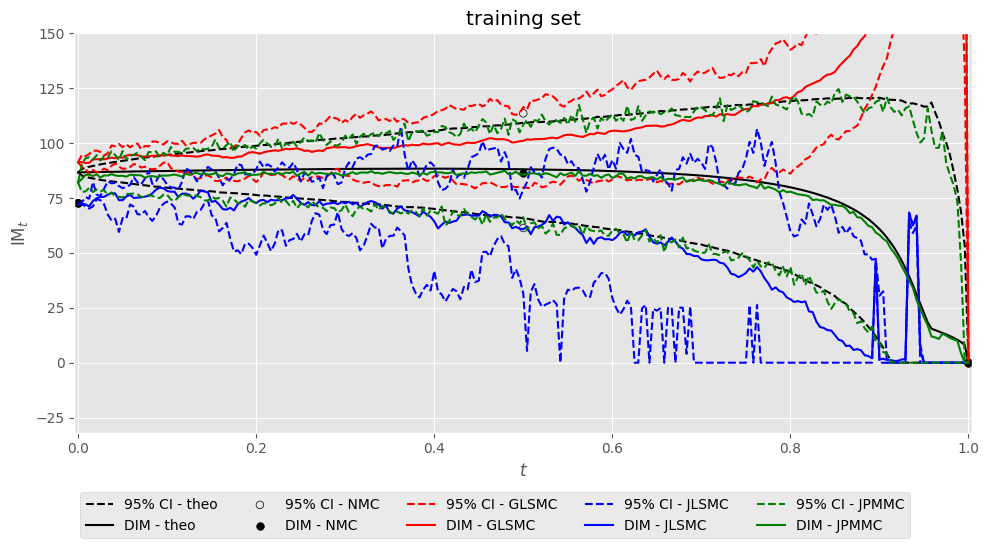

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(time_grid.grid, im_true_profile[2], linestyle='--', color='black', label='95% CI - theo')
ax.plot(time_grid.grid, im_true_profile[1], color='black', label='DIM - theo')
ax.plot(time_grid.grid, im_true_profile[0],  linestyle='--', color='black')

ax.scatter(time_grid_nested.grid, im_nmc_profile[2], s=30, facecolors='none', color='black', label='95% CI - NMC')
ax.scatter(time_grid_nested.grid, im_nmc_profile[1], s=30, color='black', label='DIM - NMC')
ax.scatter(time_grid_nested.grid, im_nmc_profile[0], s=30, facecolors='none', color='black')

ax.plot(time_grid.grid, im_glsmc_profile[2], linestyle='--', color='red', label='95% CI - GLSMC')
ax.plot(time_grid.grid, im_glsmc_profile[1], color='red', label='DIM - GLSMC')
ax.plot(time_grid.grid, im_glsmc_profile[0], linestyle='--', color='red')

ax.plot(time_grid.grid, im_jlsmc_profile[2], linestyle='--', color='blue', label='95% CI - JLSMC')
ax.plot(time_grid.grid, im_jlsmc_profile[1], color='blue', label='DIM - JLSMC')
ax.plot(time_grid.grid, im_jlsmc_profile[0], linestyle='--', color='blue')

ax.plot(time_grid.grid, im_jpmmc_profile[2], linestyle='--', color='green', label='95% CI - JPMMC')
ax.plot(time_grid.grid, im_jpmmc_profile[1], color='green', label='DIM - JPMMC')
ax.plot(time_grid.grid, im_jpmmc_profile[0], linestyle='--', color='green')

ax.set_xlabel('$t$')
ax.set_ylabel('$\\text{IM}_t$')
ax.set_xlim(np.min(time_grid.grid)-time_grid.timestep, np.max(time_grid.grid)+time_grid.timestep)
ax.set_ylim(top=150)
ax.set_title('training set')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.show()